In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']
# cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
pclFiles = {'pp->zp': '../data/2mdm_zp_jet.pcl',
            'pp->sd': '../data/2mdm_sd_jet.pcl'}
# xsecFiles = {'pp->zp': '../data/2mdm_zp_prod2.txt',
#              'pp->y0': '../data/2mdm_y0_prod.txt',
#              'pp->h2': '../data/2mdm_h2_prod.txt'}

# xsec = {}
# for label, f in xsecFiles.items():
#     xsecArr = np.genfromtxt(f, skip_header=1)
#     xsec[label] = xsecArr[:, 2].flatten()
    
df = [pd.read_pickle(f) for l, f in pclFiles.items()]

df[1]['process'] = 'pp->sd'
df[1] = df[1].drop(columns=['$m_{med}$'])
df[1] = df[1].rename(columns={'$m_{s}$': '$m_{med}$'})
    
for d in df:
    d = d.sort_values(['$m_{med}$', '$\sin\\theta$', '$g_{q}$'],inplace=True, 
                     ascending=[True, True, True])

    
# data.sort_values(['process', '$m_{zp}$', 'x-sec (pb)', '$\Gamma_{zp}$', '$g_{q}$', '$g_{\chi}$'], 
#                   inplace=True, ascending=[True,True,True,True,True,True])

In [4]:
# data = df[0]

# for val in data.values:
#     for val in list(df[0]['process']):
#         data['x-sec (pb)'] = xsec[val]
        

# for d in df:
#     for label, f in pclFiles.items():
#         d['x-sec (pb)'] = xsec[label]
#         data = pd.concat((data, df)) 

In [5]:
# data = pd.DataFrame()
# for i, d in enumerate(df):
#     for val in list(d['process']):
#         d['x-sec (pb)'] = xsec[val]
        
#     data = pd.concat((data, d)) 

In [6]:
data = pd.DataFrame()
for d in df:
    data = pd.concat((data,d))

In [8]:
# Filter model

modelFilter = {
               '$y_{\chi}$' : 1.0,
               '$g_{\chi}$': 1.0,
               '$\sin\\theta$': 0.1
               }

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in modelFilter.items()])
dfModel = data.loc[(data[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
textstr2 = '\n$g_{q}$ = 0.1'
textstr = textstr+textstr2

In [9]:
dfModel = dfModel[(dfModel['$g_{q}$'] == 0.1) | (dfModel['$g_{q}$'] == 1.0)]
dfModel = dfModel.drop(columns=['$m_{s}$', '$m_{\chi}$'])

In [10]:
dfModel

,process,$m_{med}$,$\Gamma_{zp}$,$y_{\chi}$,$\Gamma_{s}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb),x-sec pT-250 (pb)
1,pp->zp,500.0,6.557154,1.0,0.878615,1.0,0.1,0.1,10000,1.14194,0.187042
5,pp->zp,600.0,8.114722,1.0,0.878615,1.0,0.1,0.1,10000,0.664889,0.128886
14,pp->zp,700.0,9.64013,1.0,0.878615,1.0,0.1,0.1,10000,0.408198,0.084421
18,pp->zp,800.0,11.1456,1.0,0.878615,1.0,0.1,0.1,10000,0.262202,0.057376
22,pp->zp,900.0,12.63779,1.0,0.878615,1.0,0.1,0.1,10000,0.174302,0.041196
26,pp->zp,1000.0,14.12069,1.0,0.878615,1.0,0.1,0.1,10000,0.11866,0.028702
30,pp->zp,1100.0,15.59684,1.0,0.878615,1.0,0.1,0.1,10000,0.082731,0.021338
34,pp->zp,1200.0,17.06791,1.0,0.878615,1.0,0.1,0.1,10000,0.05869,0.015292
38,pp->zp,1300.0,18.53508,1.0,0.878615,1.0,0.1,0.1,10000,0.042288,0.011164
42,pp->zp,1400.0,19.99918,1.0,0.878615,1.0,0.1,0.1,10000,0.031012,0.008435


In [11]:
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(pclFiles.keys())}    

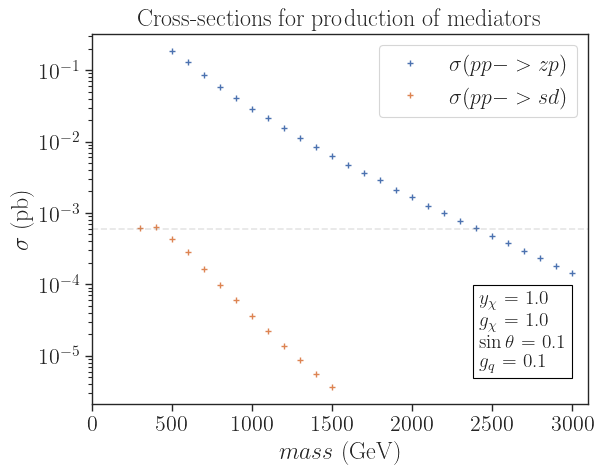

In [16]:
# plot cross-section

for label in pclFiles.keys():
    mass = np.array(dfModel['$m_{med}$'][dfModel['process'] == label])
    xsecs = np.array(dfModel['x-sec pT-250 (pb)'][dfModel['process'] == label])
    plt.plot(mass, xsecs, color=colors[label], marker='+', linestyle='', label=r'$\sigma(%s)$' %(label))

    
plt.hlines(0.0006, xmin=0.0, xmax=3100, linestyles='--', alpha=0.2, color='gray')
plt.yscale('log')

plt.title('Cross-sections for production of mediators')
plt.xlabel(r'$mass$ (GeV)')
plt.ylabel(r'$\sigma$ (pb)')

plt.text(0.78,0.1,textstr,fontsize=14,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.xlim(0.0, 3100)

plt.legend()
plt.show()

In [13]:
dfModel[dfModel['process'] == 'pp->zp']

,process,$m_{med}$,$\Gamma_{zp}$,$y_{\chi}$,$\Gamma_{s}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb),x-sec pT-250 (pb)
1,pp->zp,500.0,6.557154,1.0,0.878615,1.0,0.1,0.1,10000,1.14194,0.187042
5,pp->zp,600.0,8.114722,1.0,0.878615,1.0,0.1,0.1,10000,0.664889,0.128886
14,pp->zp,700.0,9.64013,1.0,0.878615,1.0,0.1,0.1,10000,0.408198,0.084421
18,pp->zp,800.0,11.1456,1.0,0.878615,1.0,0.1,0.1,10000,0.262202,0.057376
22,pp->zp,900.0,12.63779,1.0,0.878615,1.0,0.1,0.1,10000,0.174302,0.041196
26,pp->zp,1000.0,14.12069,1.0,0.878615,1.0,0.1,0.1,10000,0.11866,0.028702
30,pp->zp,1100.0,15.59684,1.0,0.878615,1.0,0.1,0.1,10000,0.082731,0.021338
34,pp->zp,1200.0,17.06791,1.0,0.878615,1.0,0.1,0.1,10000,0.05869,0.015292
38,pp->zp,1300.0,18.53508,1.0,0.878615,1.0,0.1,0.1,10000,0.042288,0.011164
42,pp->zp,1400.0,19.99918,1.0,0.878615,1.0,0.1,0.1,10000,0.031012,0.008435


In [14]:
dfModel[dfModel['process'] == 'pp->sd']

,process,$m_{med}$,$\Gamma_{zp}$,$y_{\chi}$,$\Gamma_{s}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb),x-sec pT-250 (pb)
2,pp->sd,300.0,28.74509,1.0,2.292376,1.0,0.1,0.1,10000,0.005752,0.000609
63,pp->sd,400.0,28.74509,1.0,3.725897,1.0,0.1,0.1,10000,0.005837,0.000635
81,pp->sd,500.0,28.74509,1.0,5.296023,1.0,0.1,0.1,10000,0.003411,0.000429
93,pp->sd,600.0,28.74509,1.0,7.027442,1.0,0.1,0.1,10000,0.001765,0.000284
105,pp->sd,700.0,28.74509,1.0,8.970945,1.0,0.1,0.1,10000,0.000918,0.000163
117,pp->sd,800.0,28.74509,1.0,11.17448,1.0,0.1,0.1,10000,0.000493,0.000097
129,pp->sd,900.0,28.74509,1.0,13.68302,1.0,0.1,0.1,10000,0.000272,0.00006
141,pp->sd,1000.0,28.74509,1.0,16.53968,1.0,0.1,0.1,10000,0.000155,0.000036
153,pp->sd,1100.0,28.74509,1.0,19.78642,1.0,0.1,0.1,10000,0.000091,0.000022
20,pp->sd,1200.0,28.74509,1.0,23.46448,1.0,0.1,0.1,10000,0.000055,0.000014
